In [2]:
import os
import shutil
import glob
import sys

import numpy as np
import random

#sys.path.append("/xddata/home/acg1fa4eq1/.conda/envs/unet3d/lib/python3.7/site-packages")
sys.path.append("/public/software/apps/anaconda3/5.2.0/envs/pytorch1.10.0a0-py37-dtk22.04.2/lib/python3.7/site-packages")
sys.path.append("/public/home/msliuzy/.local/lib/python3.7/site-packages")

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

from utils import MyDataset, cal_acc_batch


In [3]:
train_dir = "dataset/train"
val_dir = "dataset/val"
# data max: 157.5, min: -319.75
# data mean: 0.669921875, std: 0.007345963568431114

mean = 0.669921875
std = 0.007345963568431114
_max = 157.5
_min = -319.75
train_dataset = MyDataset(train_dir,mean=mean,std=std)
val_dataset = MyDataset(val_dir,mean=mean,std=std)

print(len(train_dataset))
print(len(val_dataset))

840
360


In [52]:
import copy
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import CosineAnnealingLR
from utils import mse_ce_loss

def train_model(model, train_loader, val_loader, n_epochs, 
                learning_rate,
                min_lr=1e-10, 
                decay_steps=20,
                lamda=0.5,
                is_ae=True,
                ckpt_dir="best-ckpt.pt"):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999))
    criterion = nn.L1Loss(reduction='sum').to(device)
    
    gamma = 0.5
    #scheduler = lr_scheduler.StepLR(optimizer, step_size=decay_steps, gamma=gamma)
    scheduler = CosineAnnealingLR(optimizer = optimizer, T_max = 40, eta_min=1e-5)
    
    milestones = [2, 5, 10, 20, 25, 30, 35, 40, 50, 60, 70, 80 ] 
    gamma = 0.5
    #scheduler = lr_scheduler.MultiStepLR(optimizer, milestones, gamma)
    
    
    # criterion  = nn.MSELoss().to(device)
    history = dict(train=[], val=[])
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0
    
    # 加载best_ckpt
    if os.path.exists(ckpt_dir):
        print(f'load pretrained model from {ckpt_dir}')
        model.load_state_dict(torch.load(ckpt_dir))
    else:
        print("traing start...")
  
    for epoch in range(1, n_epochs + 1):
        model = model.train()

        train_losses = []
        
        correct_sum = 0
        count = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()

            inputs = inputs.cuda()
            labels = labels.cuda().long()



            if is_ae:
                output, _labels = model(inputs)

                mse_loss, ce_loss = mse_ce_loss(output, inputs, _labels, labels)
                loss = mse_loss * lamda + ce_loss * ( 1 - lamda)
            else:
                
                _labels = model(inputs)

                if len(_labels.shape) == 1:
                    _labels  = _labels.view(1, -1)
                loss = torch.nn.CrossEntropyLoss(reduction='sum')(_labels, labels)

            #loss = ce_loss
            
            pred = _labels.max(1, keepdim=True)[1]
            
            correct = pred.eq(labels.view_as(pred)).sum().item()

            
            correct_sum += correct
            count += len(labels)
            
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item() / len(labels))
            print(f'Batch Loss: {loss.item() / len(labels):.4f} Acc: {round(correct / len(labels)* 100, 2)}', end='\r')
 
        val_losses = []
        correct_val = 0
        count_val = 0

        with torch.no_grad():
            model = model.eval()
            for inputs,labels in val_loader:

                inputs = inputs.cuda()
                labels = labels.cuda().long()

                if len(_labels.shape) == 1:
                    _labels = _labels.view(1, -1)
                #print(_labels.shape,labels.shape)
                
                if is_ae:
                    output, _labels = model(inputs)

                    mse_loss, ce_loss = mse_ce_loss(output, inputs, _labels, labels)
                    loss = mse_loss * lamda + ce_loss * ( 1 - lamda)
                else:

                    _labels = model(inputs)


                    if len(_labels.shape) == 1:
                        _labels = _labels.view(1, -1)
                    loss = torch.nn.CrossEntropyLoss(reduction='sum')(_labels, labels)

                
                pred = _labels.max(1, keepdim=True)[1]
                #print(_labels)
                correct_val += pred.eq(labels.view_as(pred)).sum().item()
                

                count_val += len(labels)
                
                val_losses.append(loss.item() / len(labels))

                
 
        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        
        history['train'].append(train_loss)
        history['val'].append(val_loss)
         
        for param_group in optimizer.param_groups:
            param_group['lr'] = max(param_group['lr'], min_lr)
            lr = param_group['lr'] 
                              
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
        train_acc = round(correct_sum / count* 100, 2)
        val_acc = round(correct_val / count_val* 100, 2)

        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}  train acc {train_acc}  val acc {val_acc} lr: {lr}')
        scheduler.step()
        if epoch > 1 and epoch % 20 == 0:
            print('Saving model...', end='\r')
            torch.save(best_model_wts,ckpt_dir)
    

            #model.load_state_dict(best_model_wts)
    return model, history


In [12]:
from model import CNN_LSTM
from model import ResNet, ResBlk

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#############################################################################################################
# 网络参数  Created by Lcy  2023.10.25
#############################################################################################################
# BestAcc     Model           Params              bidirectional-LSTM             File
#  83        CNN_LSTM         128 64 60 20              No                   CNN_LSTM_128_64_60_20_acc83.pt
#  80        Se-ResNet        blk[1 2 2 1]              Yes                  Se-ResNet_1221_acc80.pt

##############################################################################################################

# CNN_LSTM参数

input_dim = 1  # 输入信号维度
hidden_dim = 128 # cnn 
hidden_size = 64 # lstm
fc=[60,20] # fc层网络
squeeze = False # 启用SeBlock


drop_out = 0.1
n_classes = 4


model = CNN_LSTM(in_dims=input_dim, hidden_dims=hidden_dim, hidden_size=hidden_size,  num_classes=n_classes, fc=fc, squeeze=squeeze)

#model = ResNet(ResBlk,[1,2,2,1],num_classes=n_classes,cnn_channels=[24,8,8,8],lstm_dims=[32,32,1], include_top=True)

model = model.to(device)


print(model)

CNN_LSTM(
  (conv1): Sequential(
    (0): Conv1d(1, 128, kernel_size=(20,), stride=(3,), padding=(10,))
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool1d(kernel_size=2, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv1d(128, 64, kernel_size=(7,), stride=(1,), padding=(3,))
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv1d(64, 64, kernel_size=(10,), stride=(1,), padding=(5,))
    (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(64, 64, batch_first=True)
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Dropout(p=0.0, inplace=False)
    (2): Linear(in_features=64, out_features=60, bias=True)
    (3): ReLU()
    (4): Linear(i

In [55]:
# 训练参数
n_epochs = 450
learning_rate = 1e-4
min_learning_rate = 1e-8
batch_size = 1024
decay_steps = 20
lamda = 0.05


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)

model, history = train_model(
  model, 
  train_loader, 
  val_loader, 
  n_epochs=n_epochs,
  learning_rate=learning_rate,
  min_lr=min_learning_rate,
  lamda=lamda,
  decay_steps=decay_steps,
  is_ae=False
)


load pretrained model from best-ckpt.pt
Epoch 1: train loss 0.18780831836518788 val loss 0.6423427691433302  train acc 92.86  val acc 78.06 lr: 0.0001
Epoch 2: train loss 0.17805484590076265 val loss 0.6929923378235748  train acc 93.21  val acc 77.78 lr: 9.986128001799077e-05
Epoch 3: train loss 0.17366293044317335 val loss 0.7014485136752455  train acc 94.4  val acc 77.5 lr: 9.94459753267812e-05
Epoch 4: train loss 0.1758162362234933 val loss 0.691564978315609  train acc 94.88  val acc 77.78 lr: 9.875664641789545e-05
Epoch 5: train loss 0.18737369719005767 val loss 0.6760565268033158  train acc 93.81  val acc 77.22 lr: 9.779754323328191e-05
Epoch 6: train loss 0.18902224586123512 val loss 0.6645275335140985  train acc 93.45  val acc 77.5 lr: 9.65745789630079e-05
Epoch 7: train loss 0.18980705624534971 val loss 0.6522409633010536  train acc 92.14  val acc 78.06 lr: 9.509529358847654e-05
Epoch 8: train loss 0.17867896670386904 val loss 0.6405936502650029  train acc 94.4  val acc 78.89 l

In [13]:
model.load_state_dict(torch.load("CNN_LSTM_128_64_60_20_acc83.pt"))

acc, labels, losses = cal_acc_batch(model, val_dir + "/data.npy")

print(f"Acc is {acc}")

Acc is 0.8305555555555556


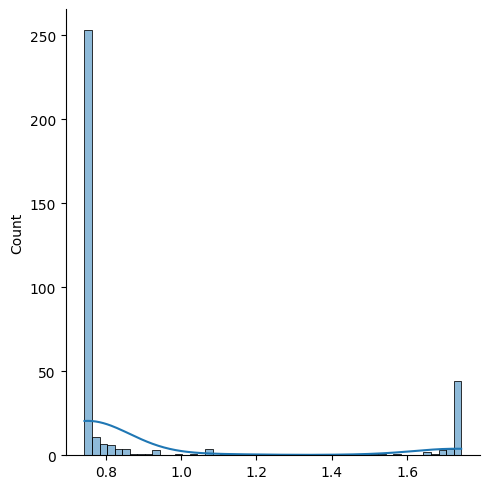

In [14]:
import seaborn as sns

sns.displot(losses, bins=50, kde=True)


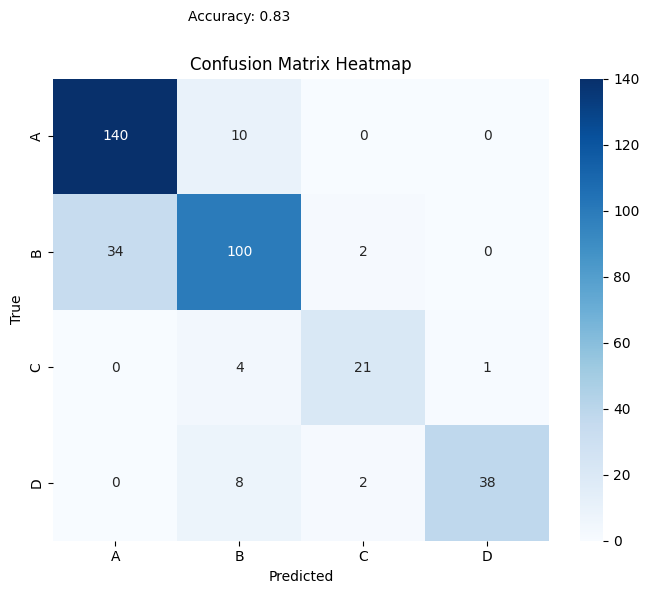

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

true_labels = labels[0]
predicted_labels = labels[1]

# 计算混淆矩阵
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# 可视化混淆矩阵热图
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['A', 'B', 'C', 'D'],
            yticklabels=['A', 'B', 'C', 'D'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')

# 显示准确度
accuracy = accuracy_score(true_labels, predicted_labels)
plt.text(1.5, -0.5, f'Accuracy: {accuracy:.2f}', ha='center')

plt.show()

In [16]:
# 直接进行二分类结果

from utils import convert_to_binary_labels, calculate_metrics


true_labels_bin = convert_to_binary_labels(labels[0])
predicted_labels_bin = convert_to_binary_labels(labels[1])

precision, recall, f1_score = calculate_metrics(true_labels_bin, predicted_labels_bin)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)


Precision: 0.946236559139785
Recall: 0.8380952380952381
F1 Score: 0.8888888888888888
